# Ensemble learning

Key take-aways
- Bagging is good at reducing the variance of a model, but not at reducing the bias. Therefore use very flexible models as base models (e.g. decision trees).
- Boosting on the other hand, can also reduce the bias of a model. 

To calculate the error of an ensemble of $n$ independent classifiers that each make errors of $\epsilon$, think of it as a Bernoulli process.
Then each classifier predicts heads with probability $1-\epsilon$. The combined error rate is then the probability that the amount of heads $k$ is smaller than $n/2$:
$$ p(k<\frac{n}{2}) = \sum_{i=1}^{n/2}(1-\epsilon)^k \epsilon^{n-k}$$ 

Let's make a plot:

Text(0, 0.5, 'Error rate')

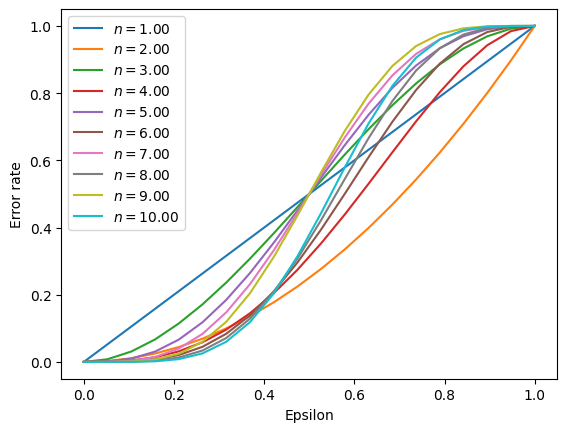

In [29]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt 
num_classifiers = list(range(1,11))
error_rates = list()
epsilons = np.linspace(0, 1, 20)
fig, ax = plt.subplots()
for n in num_classifiers:
    errors = [scipy.stats.binom.cdf(np.floor(n/2), n, 1.0-eps) if n%2 == 1 else scipy.stats.binom.cdf(np.floor(n/2)-1, n, 1.0-eps) for eps in epsilons]
    error_rates.append(errors)
    ax.plot(epsilons, errors, label=f"$n = {n:.2f}$")
plt.legend(loc='upper left')
plt.xlabel("Epsilon")
plt.ylabel("Error rate")

### Implementation of a simple majority rule algorithm

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone 
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key,value in _name_estimators(classifiers)
        }
        self.vote = vote 
        self.weights = weights
    
    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"Vote must be 'probability' or 'classlabel'; got (vote={self.vote})")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of weights and numer of classifiers must be equal')
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self 
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights), axis=1, arr=predictions))
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value 
            return out 


        
        